In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# set style 
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# define penetration data
def read_penetration(path):
    """Read a single penetration file"""
    df = pd.read_csv(
        path,
        skiprows=1,
        names=[
            "state", "county", "fips_state", "fips_cnty", "fips",
            "ssa_state", "ssa_cnty", "ssa", "eligibles", "enrolled", "penetration"
        ],
        dtype={
            "state": "string", "county": "string",
            "fips_state": "Int64", "fips_cnty": "Int64", "fips": "float64",
            "ssa_state": "Int64", "ssa_cnty": "Int64", "ssa": "float64",
            "eligibles": "string", "enrolled": "string", "penetration": "string"
        },
        na_values=["", "NA", "*", "-", "--"],
    )
    # clean numeric columns
    for c in ["eligibles", "enrolled", "penetration"]:
        df[c] = (
            df[c]
            .astype("string")
            .str.replace(",", "", regex=False)
            .str.extract(r"(-?\d+(?:\.\d+)?)")[0]
            .astype("float64")
        )
    
    return df

In [6]:
# read penetration data from 2014-2019
print("Loading penetration data...")
ma_penetration_list = []

for year in range(2014, 2020):  # 2014 through 2019
    for month in range(1, 13):  # All 12 months
        month_str = f"{month:02d}"
        file_path = f"../../../data/input/penetration_{year}/State_County_Penetration_MA_{year}_{month_str}.csv"
        
        try:
            df = read_penetration(file_path)
            df['month'] = month
            df['year'] = year
            ma_penetration_list.append(df)
            print(f"  Loaded: {year}-{month_str}")
        except FileNotFoundError:
            print(f"  File not found: {file_path}")
        except Exception as e:
            print(f"  Error loading {year}-{month_str}: {e}")

# Combine all penetration data
ma_penetration = pd.concat(ma_penetration_list, ignore_index=True)

# Sort and forward/backward fill fips codes
ma_penetration = ma_penetration.sort_values(["state", "county", "year", "month"])

ma_penetration["fips"] = (
    ma_penetration
    .groupby(["state", "county"], dropna=False)["fips"]
    .transform(lambda s: s.ffill().bfill())
)

print(f"\nTotal penetration records: {len(ma_penetration):,}")
print(f"Years covered: {sorted(ma_penetration['year'].unique())}")

Loading penetration data...
  Loaded: 2014-01
  Loaded: 2014-02
  Loaded: 2014-03
  Loaded: 2014-04
  Loaded: 2014-05
  Loaded: 2014-06
  Loaded: 2014-07
  Loaded: 2014-08
  Loaded: 2014-09
  Loaded: 2014-10
  Loaded: 2014-11
  Loaded: 2014-12
  Loaded: 2015-01
  Loaded: 2015-02
  Loaded: 2015-03
  Loaded: 2015-04
  Loaded: 2015-05
  Loaded: 2015-06
  Loaded: 2015-07
  Loaded: 2015-08
  Loaded: 2015-09
  Loaded: 2015-10
  Loaded: 2015-11
  Loaded: 2015-12
  Loaded: 2016-01
  Loaded: 2016-02
  Loaded: 2016-03
  Loaded: 2016-04
  Loaded: 2016-05
  Loaded: 2016-06
  Loaded: 2016-07
  Loaded: 2016-08
  Loaded: 2016-09
  Loaded: 2016-10
  Loaded: 2016-11
  Loaded: 2016-12
  Loaded: 2017-01
  Loaded: 2017-02
  Loaded: 2017-03
  Loaded: 2017-04
  Loaded: 2017-05
  Loaded: 2017-06
  Loaded: 2017-07
  Loaded: 2017-08
  Loaded: 2017-09
  Loaded: 2017-10
  Loaded: 2017-11
  Loaded: 2017-12
  Loaded: 2018-01
  Loaded: 2018-02
  Loaded: 2018-03
  Loaded: 2018-04
  Loaded: 2018-05
  Loaded: 2018-06


In [7]:
# calculate yearly penetration aggregates 
yearly_penetration = (
    ma_penetration
    .groupby(["fips", "state", "county", "year"], dropna=False)
    .agg(
        avg_eligibles=("eligibles", lambda s: s.mean(skipna=True)),
        avg_enrolled=("enrolled", lambda s: s.mean(skipna=True)),
    )
    .reset_index()
)

# Remove rows with missing data
yearly_penetration = yearly_penetration.dropna(subset=["avg_eligibles", "avg_enrolled"])

print(f"Yearly penetration records: {len(yearly_penetration):,}")
yearly_penetration.head()

Yearly penetration records: 18,821


,fips,state,county,year,avg_eligibles,avg_enrolled
153,60.0,American Samoa,Pending County Designation,2014,3953.166667,54.166667
154,60.0,American Samoa,Pending County Designation,2015,4015.666667,52.583333
155,60.0,American Samoa,Pending County Designation,2016,4951.250000,58.500000
156,60.0,American Samoa,Pending County Designation,2017,6974.666667,44.583333
157,60.0,American Samoa,Pending County Designation,2018,6652.166667,71.833333


In [9]:
# load ma plan data 
print("Loading plan data from ma_data files...")
plan_data_list = []

for year in range(2014, 2020):
    file_path = f"../../../data/output/ma_data_{year}.csv"
    try:
        df = pd.read_csv(file_path)
        df['year'] = year
        plan_data_list.append(df)
        print(f"  Loaded: ma_data_{year}.csv ({len(df):,} records)")
    except FileNotFoundError:
        print(f"  File not found: {file_path}")
    except Exception as e:
        print(f"  Error loading {year}: {e}")

# Combine all plan data
plan_data = pd.concat(plan_data_list, ignore_index=True)

print(f"\nTotal plan records: {len(plan_data):,}")
print(f"Columns in plan data: {list(plan_data.columns)}")

# Display first few rows to understand structure
print("\nFirst few rows of plan data:")
plan_data.head()

Loading plan data from ma_data files...
  Loaded: ma_data_2014.csv (65,095 records)


/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_13026/2701552519.py:8: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_13026/2701552519.py:8: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


  Loaded: ma_data_2015.csv (67,505 records)
  Loaded: ma_data_2016.csv (70,772 records)


/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_13026/2701552519.py:8: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_13026/2701552519.py:8: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


  Loaded: ma_data_2017.csv (72,733 records)
  Loaded: ma_data_2018.csv (87,708 records)
  Loaded: ma_data_2019.csv (97,772 records)

Total plan records: 461,585
Columns in plan data: ['contractid', 'planid', 'fips', 'year', 'state_plan', 'county_plan', 'org_type_plan', 'plan_type_plan', 'partd', 'snp', 'eghp_plan', 'org_name_plan', 'org_marketing_name', 'plan_name', 'parent_org', 'contract_date', 'enrollment', 'state_sa', 'county_sa', 'org_name_sa', 'org_type_sa', 'plan_type_sa', 'partial', 'eghp_sa', 'ssa', 'notes']

First few rows of plan data:


,contractid,planid,fips,year,state_plan,county_plan,org_type_plan,plan_type_plan,partd,snp,...,enrollment,state_sa,county_sa,org_name_sa,org_type_sa,plan_type_sa,partial,eghp_sa,ssa,notes
0,H0022,1,39023.0,2014,OH,Clark,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,...,81.0,OH,Clark,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36110.0,NaN
1,H0022,1,39035.0,2014,OH,Cuyahoga,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,...,344.0,OH,Cuyahoga,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36170.0,NaN
2,H0022,1,39051.0,2014,OH,Fulton,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,...,24.0,OH,Fulton,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36260.0,NaN
3,H0022,1,39055.0,2014,OH,Geauga,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,...,NaN,OH,Geauga,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36280.0,NaN
4,H0022,1,39057.0,2014,OH,Greene,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,...,135.0,OH,Greene,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36290.0,NaN


In [10]:
# define HHI calculation function
def calculate_hhi(enrollment_series):
    """
    Calculate Herfindahl-Hirschman Index (HHI)
    HHI = sum of squared market shares (in percentage points)
    
    HHI ranges:
    - HHI < 1,500: Unconcentrated market
    - 1,500 ≤ HHI < 2,500: Moderately concentrated
    - HHI ≥ 2,500: Highly concentrated
    """
    # Remove NaN values
    enrollment_series = enrollment_series.dropna()
    
    total_enrollment = enrollment_series.sum()
    if total_enrollment == 0 or pd.isna(total_enrollment):
        return np.nan
    
    # Calculate market shares (as percentages)
    market_shares = (enrollment_series / total_enrollment) * 100
    
    # HHI is sum of squared market shares
    hhi = (market_shares ** 2).sum()
    
    return hhi

In [12]:
# calculating HHI for each county-year

# Identify the enrollment column
if 'avg_enrollment' in plan_data.columns:
    enrollment_col = 'avg_enrollment'
elif 'enrollment' in plan_data.columns:
    enrollment_col = 'enrollment'
elif 'total_enrollment' in plan_data.columns:
    enrollment_col = 'total_enrollment'
else:
    # Try to find any column with 'enroll' in the name
    enrollment_col = [col for col in plan_data.columns if 'enroll' in col.lower()][0]
    print(f"Using column '{enrollment_col}' for enrollment")

# Ensure fips is numeric for merging
plan_data['fips'] = pd.to_numeric(plan_data['fips'], errors='coerce')

# Calculate HHI by county-year
print("Calculating HHI by county-year...")

hhi_by_county_year = (
    plan_data
    .dropna(subset=['fips', enrollment_col])
    .groupby(['fips', 'year'])
    .apply(lambda x: calculate_hhi(x[enrollment_col]))
    .reset_index()
    .rename(columns={0: 'hhi'})
)

print(f"HHI calculated for {len(hhi_by_county_year):,} county-year combinations")
print(f"Counties with HHI data: {hhi_by_county_year['fips'].nunique():,}")

# Calculate average HHI by year
avg_hhi_by_year = (
    hhi_by_county_year
    .groupby('year')['hhi']
    .agg(['mean', 'median', 'std', 'min', 'max', 'count'])
    .reset_index()
    .rename(columns={'mean': 'avg_hhi', 'count': 'n_counties'})
)

print("\nAVERAGE HHI BY YEAR (Question 3)")
print("="*70)
avg_hhi_by_year

Calculating HHI by county-year...
HHI calculated for 17,950 county-year combinations
Counties with HHI data: 3,057

AVERAGE HHI BY YEAR (Question 3)


,year,avg_hhi,median,std,min,max,n_counties
0,2014,3575.076257,2949.283711,2266.957369,641.051688,10000.0,2987
1,2015,3553.588442,2897.806855,2234.043142,651.389713,10000.0,2983
2,2016,3532.087237,2852.097166,2273.019149,686.240961,10000.0,3000
3,2017,3543.860009,2863.848883,2276.799979,619.862121,10000.0,2991
4,2018,3376.434163,2734.852910,2193.439192,538.558720,10000.0,2996
5,2019,3036.937777,2400.850778,2115.239760,485.877579,10000.0,2993


In [13]:
# calculate ma penetration share 
print("Calculating MA penetration rates...")

# Calculate national average MA penetration by year
ma_share_by_year = (
    yearly_penetration
    .groupby("year")
    .agg(
        total_eligibles=("avg_eligibles", "sum"),
        total_enrolled=("avg_enrolled", "sum"),
        n_counties=("fips", "count")
    )
    .reset_index()
)

ma_share_by_year["ma_share"] = (
    ma_share_by_year["total_enrolled"] / ma_share_by_year["total_eligibles"] * 100
)

print("\nMA PENETRATION BY YEAR (Question 4)")
print("="*70)
ma_share_by_year[["year", "ma_share", "total_eligibles", "total_enrolled"]]

Calculating MA penetration rates...

MA PENETRATION BY YEAR (Question 4)


,year,ma_share,total_eligibles,total_enrolled
0,2014,30.477161,5.315286e+07,1.619948e+07
1,2015,31.998483,5.459873e+07,1.747077e+07
2,2016,32.585928,5.638546e+07,1.837373e+07
3,2017,33.964717,5.830364e+07,1.980267e+07
4,2018,34.605850,6.160367e+07,2.131847e+07
5,2019,37.879592,6.048678e+07,2.291215e+07


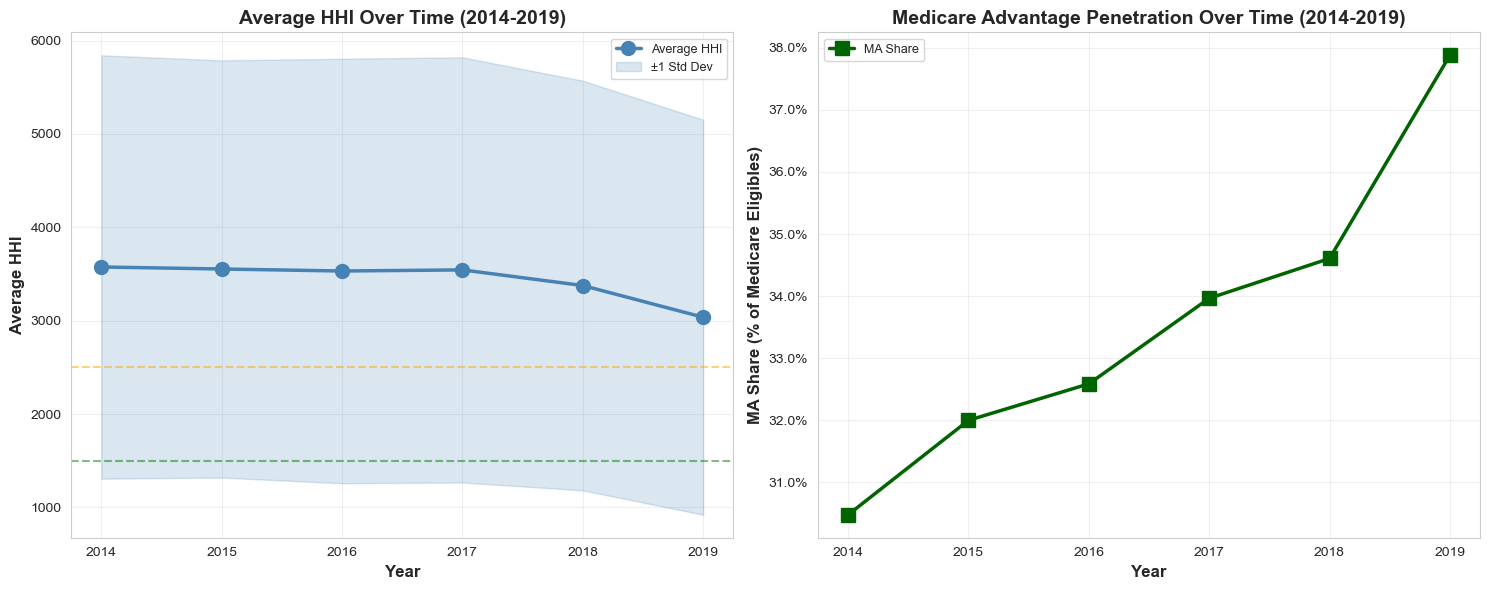


Combined plot saved to: ../../../data/output/hhi_and_ma_share.png


In [25]:
# Combined plot for Questions 3 & 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ---- PLOT 1: Average HHI Over Time (Question 3) ----
ax1.plot(avg_hhi_by_year["year"], avg_hhi_by_year["avg_hhi"], 
         marker='o', linewidth=2.5, markersize=10, color='steelblue', label='Average HHI')
ax1.fill_between(avg_hhi_by_year["year"], 
                  avg_hhi_by_year["avg_hhi"] - avg_hhi_by_year["std"], 
                  avg_hhi_by_year["avg_hhi"] + avg_hhi_by_year["std"], 
                  alpha=0.2, color='steelblue', label='±1 Std Dev')

ax1.set_xlabel("Year", fontsize=12, fontweight='bold')
ax1.set_ylabel("Average HHI", fontsize=12, fontweight='bold')
ax1.set_title("Average HHI Over Time (2014-2019)", fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(2014, 2020))

ax1.axhline(y=1500, color='green', linestyle='--', alpha=0.5, linewidth=1.5)
ax1.axhline(y=2500, color='orange', linestyle='--', alpha=0.5, linewidth=1.5)
ax1.legend(loc='best', fontsize=9)

# ---- PLOT 2: MA Share Over Time (Question 4) ----
ax2.plot(ma_share_by_year["year"], ma_share_by_year["ma_share"], 
         marker='s', linewidth=2.5, markersize=10, color='darkgreen', label='MA Share')
ax2.set_xlabel("Year", fontsize=12, fontweight='bold')
ax2.set_ylabel("MA Share (% of Medicare Eligibles)", fontsize=12, fontweight='bold')
ax2.set_title("Medicare Advantage Penetration Over Time (2014-2019)", 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(2014, 2020))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}%'))
ax2.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.draw()
plt.savefig("../../../data/output/hhi_and_ma_share.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\nCombined plot saved to: ../../../data/output/hhi_and_ma_share.png")

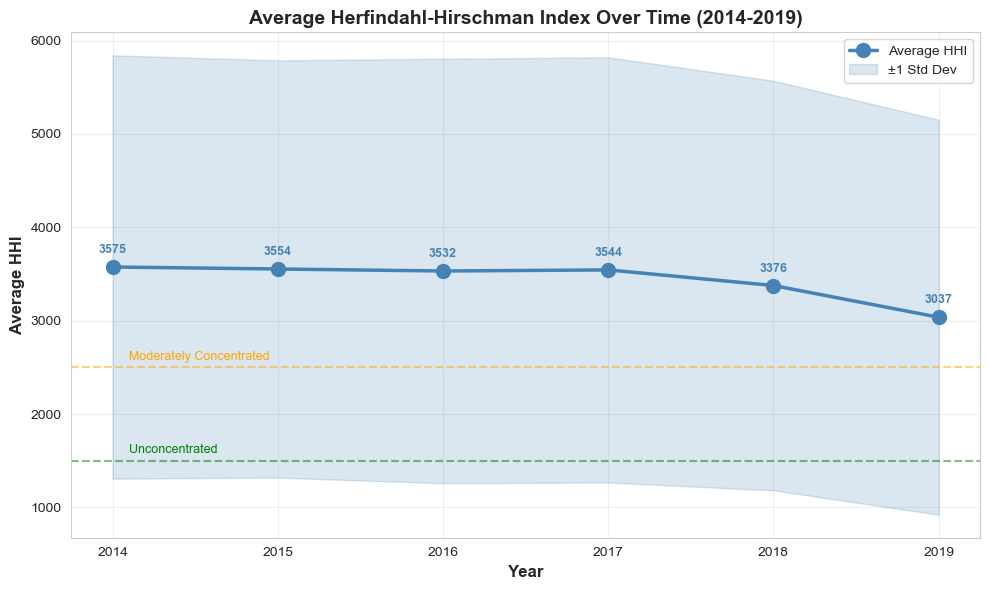

Question 3 plot saved to: ../../../data/output/question3_hhi.png


In [26]:
# Individual plot for Question 3 (HHI)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(avg_hhi_by_year["year"], avg_hhi_by_year["avg_hhi"], 
        marker='o', linewidth=2.5, markersize=10, color='steelblue', label='Average HHI')
ax.fill_between(avg_hhi_by_year["year"], 
                 avg_hhi_by_year["avg_hhi"] - avg_hhi_by_year["std"], 
                 avg_hhi_by_year["avg_hhi"] + avg_hhi_by_year["std"], 
                 alpha=0.2, color='steelblue', label='±1 Std Dev')

ax.set_xlabel("Year", fontsize=12, fontweight='bold')
ax.set_ylabel("Average HHI", fontsize=12, fontweight='bold')
ax.set_title("Average Herfindahl-Hirschman Index Over Time (2014-2019)", 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(2014, 2020))

ax.axhline(y=1500, color='green', linestyle='--', alpha=0.5, linewidth=1.5)
ax.axhline(y=2500, color='orange', linestyle='--', alpha=0.5, linewidth=1.5)
ax.text(2014.1, 1550, 'Unconcentrated', fontsize=9, va='bottom', color='green')
ax.text(2014.1, 2550, 'Moderately Concentrated', fontsize=9, va='bottom', color='orange')

for idx, row in avg_hhi_by_year.iterrows():
    ax.annotate(f'{row["avg_hhi"]:.0f}', 
                xy=(row["year"], row["avg_hhi"]),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=9, color='steelblue', fontweight='bold')

ax.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.draw()
plt.savefig("../../../data/output/question3_hhi.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Question 3 plot saved to: ../../../data/output/question3_hhi.png")

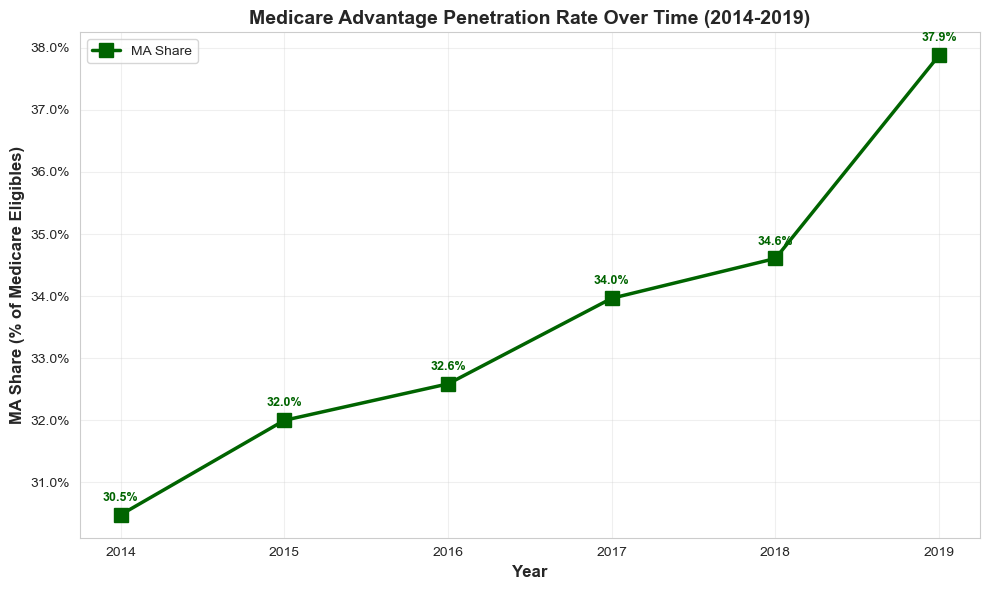

Question 4 plot saved to: ../../../data/output/question4_ma_share.png


In [27]:
# Individual plot for Question 4 (MA Share)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ma_share_by_year["year"], ma_share_by_year["ma_share"], 
        marker='s', linewidth=2.5, markersize=10, color='darkgreen', label='MA Share')
ax.set_xlabel("Year", fontsize=12, fontweight='bold')
ax.set_ylabel("MA Share (% of Medicare Eligibles)", fontsize=12, fontweight='bold')
ax.set_title("Medicare Advantage Penetration Rate Over Time (2014-2019)", 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(2014, 2020))

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}%'))

for idx, row in ma_share_by_year.iterrows():
    ax.annotate(f'{row["ma_share"]:.1f}%', 
                xy=(row["year"], row["ma_share"]),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=9, color='darkgreen', fontweight='bold')

ax.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.draw()
plt.savefig("../../../data/output/question4_ma_share.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Question 4 plot saved to: ../../../data/output/question4_ma_share.png")

In [20]:
# analyzing and interpreting hhi and ma share data
print("="*70)
print("ANALYSIS AND INTERPRETATION")
print("="*70)

# HHI Analysis
hhi_2014 = avg_hhi_by_year[avg_hhi_by_year['year'] == 2014]['avg_hhi'].values[0]
hhi_2019 = avg_hhi_by_year[avg_hhi_by_year['year'] == 2019]['avg_hhi'].values[0]
hhi_change = hhi_2019 - hhi_2014
hhi_pct_change = (hhi_change / hhi_2014) * 100

print("\n📊 Question 3 - HHI Over Time:")
print(f"  2014 Average HHI: {hhi_2014:.2f}")
print(f"  2019 Average HHI: {hhi_2019:.2f}")
print(f"  Absolute Change: {hhi_change:+.2f}")
print(f"  Percentage Change: {hhi_pct_change:+.2f}%")

print("\n  Interpretation:")
if hhi_change > 0:
    print("  → HHI has INCREASED over time, indicating GREATER market concentration")
    print("    This means the Medicare Advantage market has become MORE concentrated,")
    print("    with fewer plans controlling larger shares of enrollment.")
    if hhi_2019 >= 2500:
        print("    ⚠️  The market is now HIGHLY CONCENTRATED (HHI ≥ 2,500)")
    elif hhi_2019 >= 1500:
        print("    ⚠️  The market is MODERATELY CONCENTRATED (HHI 1,500-2,500)")
    else:
        print("    ✓ The market is still UNCONCENTRATED (HHI < 1,500)")
else:
    print("  → HHI has DECREASED over time, indicating LESS market concentration")
    print("    This means the Medicare Advantage market has become MORE competitive,")
    print("    with market share more evenly distributed among plans.")

# MA Share Analysis
ma_2014 = ma_share_by_year[ma_share_by_year['year'] == 2014]['ma_share'].values[0]
ma_2019 = ma_share_by_year[ma_share_by_year['year'] == 2019]['ma_share'].values[0]
ma_change = ma_2019 - ma_2014
ma_relative_change = (ma_change / ma_2014) * 100

print("\n📈 Question 4 - MA Penetration Over Time:")
print(f"  2014 MA Share: {ma_2014:.2f}%")
print(f"  2019 MA Share: {ma_2019:.2f}%")
print(f"  Absolute Change: {ma_change:+.2f} percentage points")
print(f"  Relative Growth: {ma_relative_change:+.2f}%")

print("\n  Interpretation:")
if ma_change > 0:
    print("  → Medicare Advantage has INCREASED in popularity")
    print(f"    The share of Medicare beneficiaries enrolled in MA plans grew by")
    print(f"    {ma_change:.2f} percentage points ({ma_relative_change:.1f}% relative increase)")
    print("    This indicates a growing preference for MA over traditional Medicare.")
else:
    print("  → Medicare Advantage has DECREASED in popularity")
    print(f"    The share of Medicare beneficiaries enrolled in MA plans fell by")
    print(f"    {abs(ma_change):.2f} percentage points ({abs(ma_relative_change):.1f}% relative decrease)")

# Calculate year-over-year changes
print("\n📊 Year-over-Year Changes:")
print("\n  HHI:")
for i in range(len(avg_hhi_by_year) - 1):
    year = avg_hhi_by_year.iloc[i]['year']
    next_year = avg_hhi_by_year.iloc[i+1]['year']
    hhi_yoy = avg_hhi_by_year.iloc[i+1]['avg_hhi'] - avg_hhi_by_year.iloc[i]['avg_hhi']
    print(f"    {year} → {next_year}: {hhi_yoy:+.2f}")

print("\n  MA Share:")
for i in range(len(ma_share_by_year) - 1):
    year = ma_share_by_year.iloc[i]['year']
    next_year = ma_share_by_year.iloc[i+1]['year']
    ma_yoy = ma_share_by_year.iloc[i+1]['ma_share'] - ma_share_by_year.iloc[i]['ma_share']
    print(f"    {year} → {next_year}: {ma_yoy:+.2f} pp")

ANALYSIS AND INTERPRETATION

📊 Question 3 - HHI Over Time:
  2014 Average HHI: 3575.08
  2019 Average HHI: 3036.94
  Absolute Change: -538.14
  Percentage Change: -15.05%

  Interpretation:
  → HHI has DECREASED over time, indicating LESS market concentration
    This means the Medicare Advantage market has become MORE competitive,
    with market share more evenly distributed among plans.

📈 Question 4 - MA Penetration Over Time:
  2014 MA Share: 30.48%
  2019 MA Share: 37.88%
  Absolute Change: +7.40 percentage points
  Relative Growth: +24.29%

  Interpretation:
  → Medicare Advantage has INCREASED in popularity
    The share of Medicare beneficiaries enrolled in MA plans grew by
    7.40 percentage points (24.3% relative increase)
    This indicates a growing preference for MA over traditional Medicare.

📊 Year-over-Year Changes:

  HHI:
    2014.0 → 2015.0: -21.49
    2015.0 → 2016.0: -21.50
    2016.0 → 2017.0: +11.77
    2017.0 → 2018.0: -167.43
    2018.0 → 2019.0: -339.50

  M

In [21]:
# saving results

# Save detailed HHI results
avg_hhi_by_year.to_csv("../../../data/output/avg_hhi_by_year.csv", index=False)
hhi_by_county_year.to_csv("../../../data/output/hhi_by_county_year.csv", index=False)

# Save MA penetration results
ma_share_by_year.to_csv("../../../data/output/ma_share_by_year.csv", index=False)
yearly_penetration.to_csv("../../../data/output/yearly_penetration_by_county.csv", index=False)

print("="*70)
print("FILES SAVED")
print("="*70)
print("Results saved to:")
print("  - ../../../data/output/avg_hhi_by_year.csv")
print("  - ../../../data/output/hhi_by_county_year.csv")
print("  - ../../../data/output/ma_share_by_year.csv")
print("  - ../../../data/output/yearly_penetration_by_county.csv")
print("\nPlots saved to:")
print("  - ../../../data/output/hhi_and_ma_share.png (combined)")
print("  - ../../../data/output/question3_hhi.png (HHI only)")
print("  - ../../../data/output/question4_ma_share.png (MA share only)")
print("="*70)

FILES SAVED
Results saved to:
  - ../../../data/output/avg_hhi_by_year.csv
  - ../../../data/output/hhi_by_county_year.csv
  - ../../../data/output/ma_share_by_year.csv
  - ../../../data/output/yearly_penetration_by_county.csv

Plots saved to:
  - ../../../data/output/hhi_and_ma_share.png (combined)
  - ../../../data/output/question3_hhi.png (HHI only)
  - ../../../data/output/question4_ma_share.png (MA share only)
